In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
# configure matplotlib
%matplotlib notebook
# %matplotlib inline

In [3]:
from cdi.util.stats_utils import load_statistics

from cdi.util.analysis.plotting import plot_comparison, plot_chains
from cdi.util.analysis.logs import collate_stats, trace_data_chains

## Analysis setup

In [5]:
data_name = 'toy_set3'
exp_seed_key = 'm20190508_d20200325_20200406_20200407'

### Templates

In [6]:
log_path_template = f'../../trained_models/{data_name}/learning_experiments/{{}}/{{}}/{exp_seed_key}/logs/{{}}'

## Helpers

In [8]:
def read_experiment_stats(group, model):
    path = log_path_template.format(group, model, 'summary.csv')
    filename = os.path.basename(path)
    dirpath = os.path.dirname(path)
    return load_statistics(dirpath, filename)

def read_suite_stats(group, suite):
    return {
        name: read_experiment_stats(group, model)
        for name, model in suite.items()
    }

def read_all_suite_stats(groups, suite):
    return {
        group: read_suite_stats(group, suite)
        for group in groups
    }

## Analysis

### Learning curves

In [10]:
suite = {
    'VCDI Test': 'fa_variational_cdi_mi5_test',
}

<IPython.core.display.Javascript object>


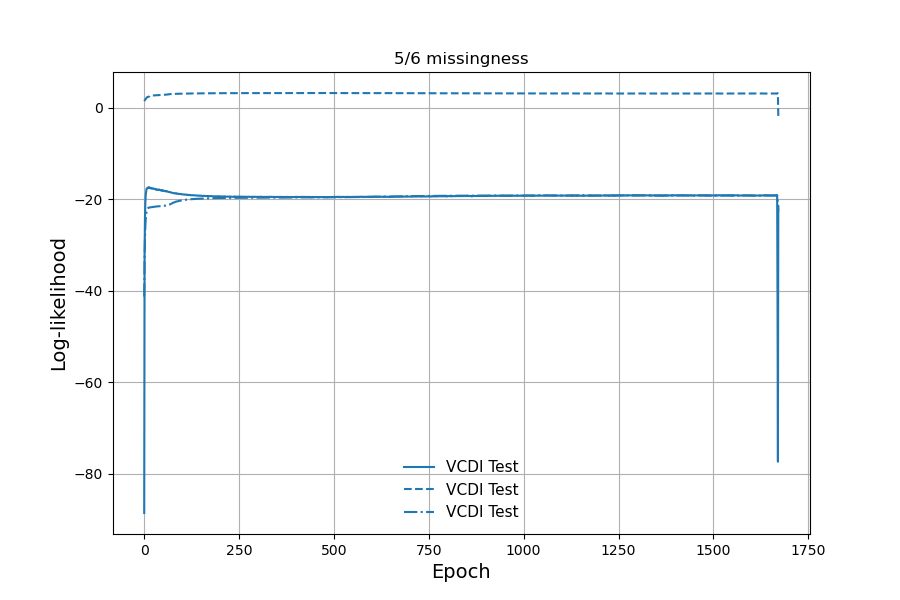

In [44]:
fig, axes = plt.subplots(nrows=1, ncols=1, sharey=True, figsize=(9, 6))
stats = read_suite_stats(group=5, suite=suite)

axes.set(title=f'5/6 missingness')
plot_comparison(axes, stats, 
                x_metric_key='curr_epoch',
#                 y_metric_keys=('val_log_lik',),  
#                 y_metric_keys=('train_entropy',),  
#                 y_metric_keys=('train_log_lik',), 
                y_metric_keys=('train_log_lik', 'train_entropy', 'val_log_lik'),# 'val_log_lik'),
                err_keys=(None, None, None,),
#                 err_keys=(None, None),
#                 err_keys=(None, ),
                xlabel='Epoch',
                ylabel='Log-likelihood', 
                ylim=None)
#                     ylim=(-22, -19))
#                     ylim=(-26, -17))


### Trace data chains with largest magnitudes at the end of training (crash)

In [12]:
indices_traced = np.array([0,                                 # For reference
                           365, 35758, 15725, 6446, #30175,   # Dim 1 topk with magnitude >1e2
                           15487, 1238, 6629, 34447, #25428,  # Dim 4 topk with magnitude >1e2
                           5729, 25493, 7925, 7261],#15488],  # Dim 5 topk with magnitude >1e2
                          dtype=np.long)
group = 5
model = 'fa_variational_cdi_mi5_test'
chains = trace_data_chains(dirname=log_path_template.format(group, model, 'tensors'), 
                           logname='data',
                           indices=indices_traced)
# Show which values are observed
chains['M'][0]

array([[ True,  True, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False,  True, False, False],
       [False, False, False,  True, False, False],
       [False,  True, False, False, False,  True],
       [False, False, False, False, False, False],
       [False, False, False,  True, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False,  True, False, False, False],
       [False,  True, False, False, False, False],
       [ True, False,  True, False, False, False]])

<IPython.core.display.Javascript object>


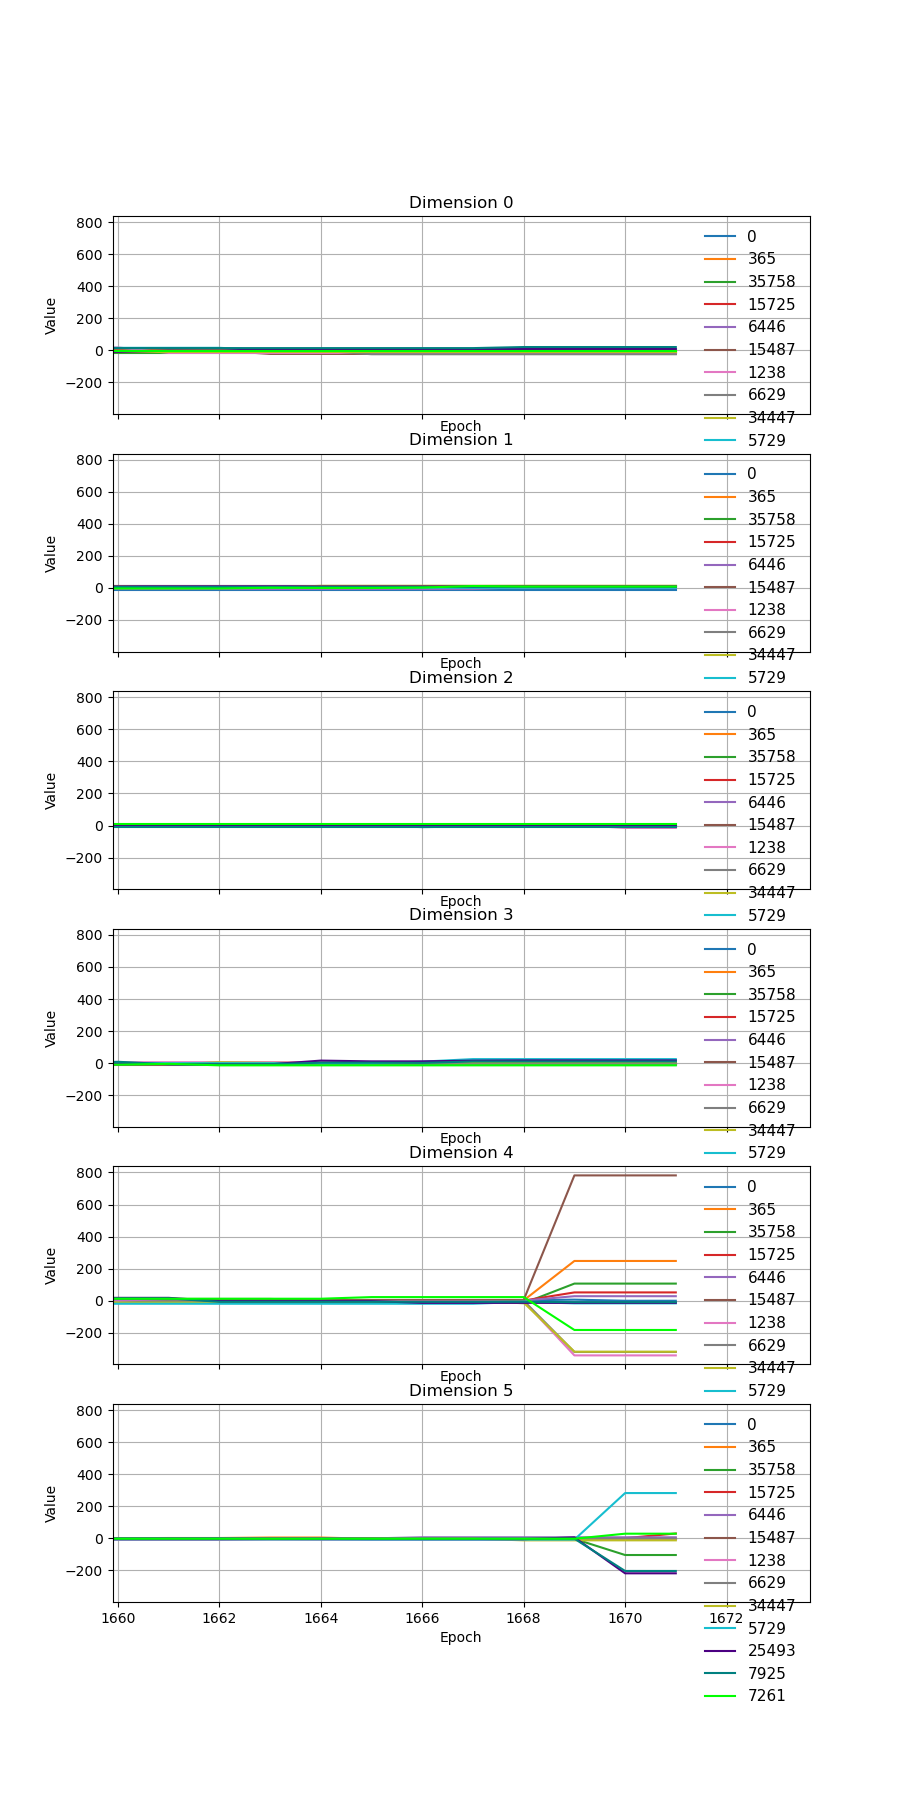

In [13]:
fig, axes = plt.subplots(nrows=chains['X'].shape[-1], ncols=1, sharex=True, sharey=True, figsize=(9, 18))
for i in range(chains['X'].shape[-1]):
    axes[i].set(title=f'Dimension {i}')
    plot_chains(axes[i], 
                epochs=chains['curr_epoch'], 
                chains=chains['X'][:, :, i], 
                labels=chains['I'][0, :],
                ylim=None)


We see that at first, the magnitudes of values in dimension 4 explode at epoch 1669.
Then, in the next epochs the dimension 5 follows due to the large values in dim 4 (?).

<IPython.core.display.Javascript object>


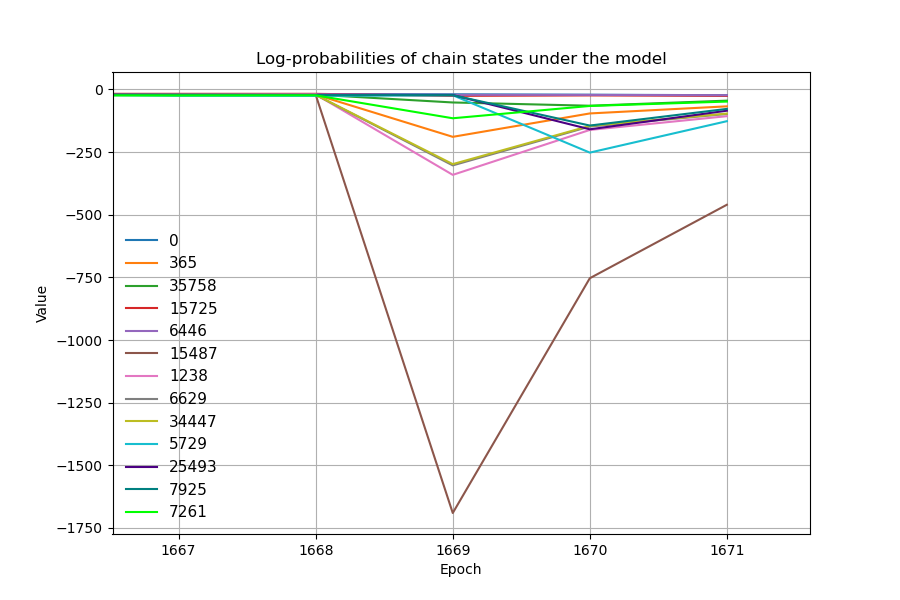

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(9, 6))

axes.set(title=f'Log-probabilities of chain states under the model')
plot_chains(axes, 
            epochs=chains['curr_epoch'], 
            chains=chains['P'], 
            labels=chains['I'][0, :],
            ylim=None)


### Trace single data chain



In [48]:
chains = trace_data_chains(dirname=log_path_template.format(5, 'fa_variational_cdi_mi5_test', 'tensors'), 
                           logname='data',
                           indices=np.array([15487], dtype=np.long))
# Show which values are observed
chains['M'][0]

array([[False,  True, False, False, False,  True]])

<IPython.core.display.Javascript object>


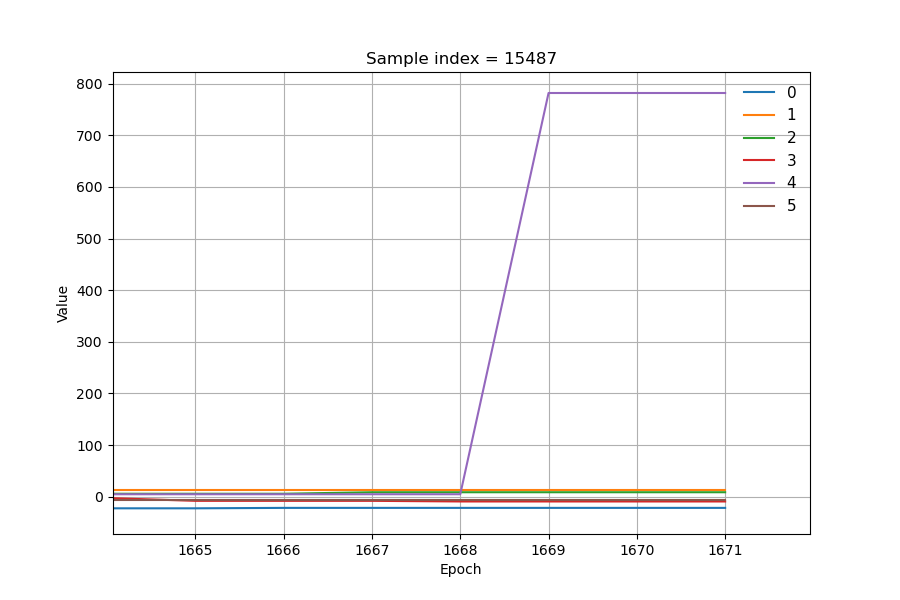

In [49]:
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(9, 6))

axes.set(title=f'Sample index = {chains["I"][0, :].item()}')
plot_chains(axes,
            epochs=chains['curr_epoch'],
            chains=chains['X'].squeeze(), 
            labels=list(np.arange(chains['X'].shape[-1])),
            ylim=None)


We confirm that the large magnitude values appear in epoch 1669 only.

<IPython.core.display.Javascript object>


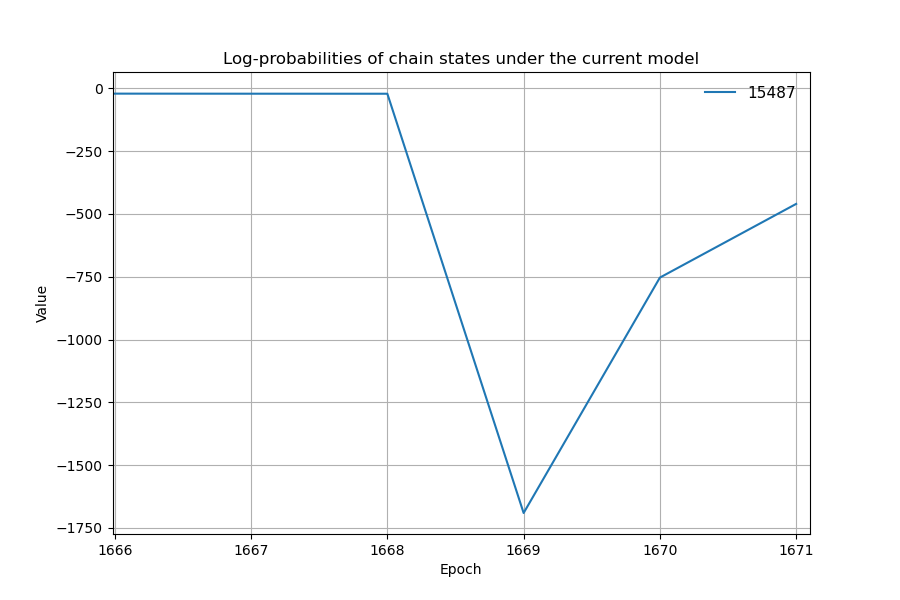

In [50]:
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(9, 6))

axes.set(title=f'Log-probabilities of chain states under the current model')
plot_chains(axes, 
            epochs=chains['curr_epoch'], 
            chains=chains['P'], 
            labels=chains['I'][0, :],
            ylim=None)


In [57]:
group = 5
model = 'fa_variational_cdi_mi5_test'
var_params = trace_data_chains(dirname=log_path_template.format(group, model, 'tensors'), 
                               logname='var_params',
                               epochs=chains['curr_epoch'][1:], # Skip 0-th epoch because imputation starts from 1-st epoch
                               indices=np.array([15487], dtype=np.long))
# The indices of selected samples
var_params['I'][0]

array([15487], dtype=int32)

In [58]:
var_params['log_var'][var_params['log_var'] == float('-inf')] = 0

<IPython.core.display.Javascript object>


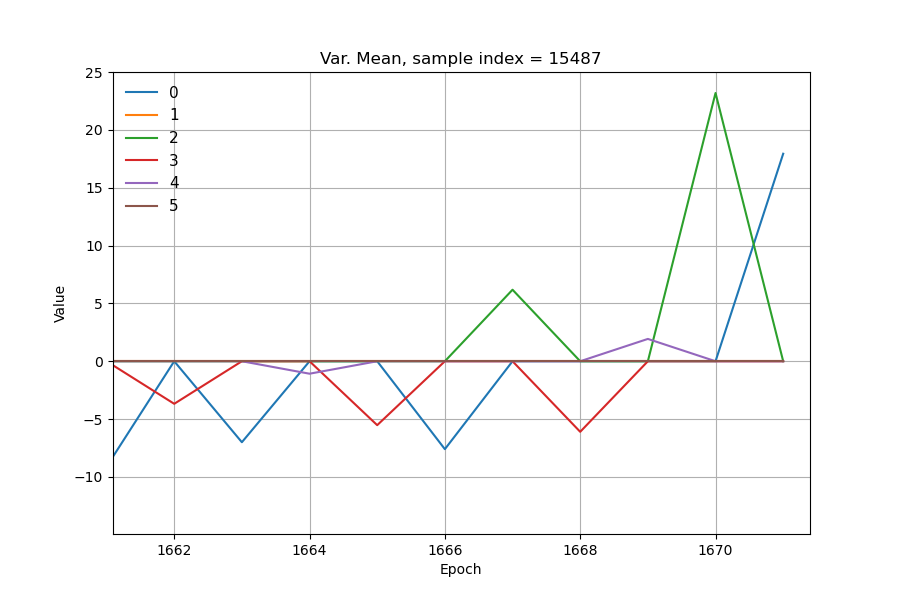

In [59]:
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(9, 6))

axes.set(title=f'Var. Mean, sample index = {var_params["I"][0, :].item()}')
plot_chains(axes, 
            epochs=var_params['curr_epoch'], 
            chains=var_params['mean'].squeeze(), 
            labels=list(np.arange(var_params['mean'].shape[-1])),
            ylim=None)


<IPython.core.display.Javascript object>


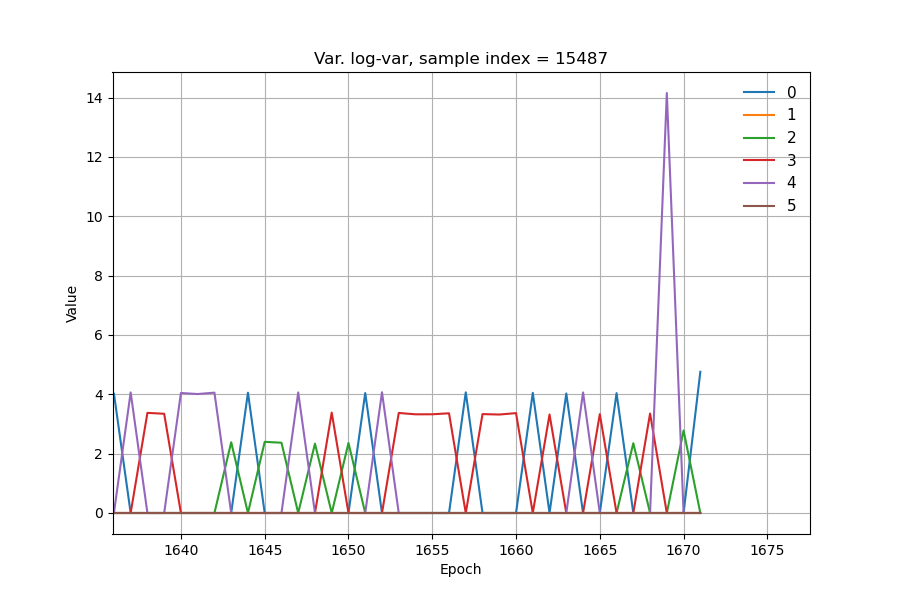

In [60]:
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(9, 6))

axes.set(title=f'Var. log-var, sample index = {var_params["I"][0, :].item()}')
plot_chains(axes, 
            epochs=var_params['curr_epoch'], 
            chains=var_params['log_var'].squeeze(), 
            labels=list(np.arange(var_params['mean'].shape[-1])),
            ylim=None)


Here we see that the log-variance of the variational posterior jumped. We also see that the mean for dimension 4 had changed significantly since its last predictions. This suggests, that something must have altered the variational distribution model for dimension 4 in the _previous epoch_.

In [55]:
chains['M'][0]

array([[False,  True, False, False, False,  True]])

In [56]:
chains['X'][1666:1670]

array([[[-21.576317 ,  12.933846 ,   5.813656 ,  -7.9275465,
           4.82247  ,  -5.7066503]],

       [[-21.576317 ,  12.933846 ,   8.720053 ,  -7.9275465,
           4.82247  ,  -5.7066503]],

       [[-21.576317 ,  12.933846 ,   8.720053 ,  -9.161737 ,
           4.82247  ,  -5.7066503]],

       [[-21.576317 ,  12.933846 ,   8.720053 ,  -9.161737 ,
         781.88934  ,  -5.7066503]]], dtype=float32)

### Investigate Epoch 1668
#### Find data chain states with largest magnitudes

In [27]:
epoch_1668 = trace_data_chains(dirname=log_path_template.format(5, 'fa_variational_cdi_mi5_test', 'tensors'), 
                               logname='data',
                               epochs=[1668])
# Show which values are observed
epoch_1668['M'][0]

array([[ True,  True, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       ...,
       [False, False,  True,  True, False,  True],
       [False, False, False, False,  True, False],
       [False, False, False, False, False, False]])

In [28]:
max_mags, max_idx = torch.topk(torch.abs(torch.tensor(epoch_1668['X'].squeeze())), dim=0, k=5)
print(max_mags)
# Get real idx of the data sample
max_idx = epoch_1668['I'][-1][max_idx.flatten()].reshape(max_idx.shape)
print(max_idx)

tensor([[41.7269, 25.8942, 16.7490, 27.6680, 35.2885, 22.0447],
        [37.7001, 25.6718, 15.2271, 25.8110, 35.0481, 21.6998],
        [37.5354, 25.5568, 15.1675, 25.1456, 34.9882, 21.6746],
        [37.3916, 25.5568, 14.9739, 24.8968, 34.4382, 21.0875],
        [37.3719, 25.5568, 14.9442, 24.8299, 33.2411, 20.9582]])
[[25031 14699 38242 39801 18534 31811]
 [39075 21685 36887  1696 37177 15946]
 [28829 18465 29867  5729 24612 24707]
 [  493  2465 38125 19916 13444  2319]
 [ 4311 10465 14692 20295 20586 25872]]


None of the values seem to have particularly high magnitudes. Next, we plot the full chain for these samples to see if any of them had exploded later on.

#### Plot full chains for the data with largest magnitudes in epoch 1668

In [29]:
group = 5
model = 'fa_variational_cdi_mi5_test'
chains2 = trace_data_chains(dirname=log_path_template.format(group, model, 'tensors'), 
                           logname='data',
                           indices=max_idx.flatten())
# Show which values are observed
chains2['M'][0]

array([[False, False, False, False, False,  True],
       [False, False, False, False, False, False],
       [ True, False, False, False, False,  True],
       [False,  True, False, False,  True, False],
       [ True, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False,  True, False,  True],
       [False, False, False, False, False,  True],
       [False, False, False, False, False, False],
       [False, False, False, False, False,  True],
       [False, False, False,  True, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False,  True,  True],
       [False,  True,  True, False, False, False],
       [False, False, False, False,  True,  True],
       [False, False, False, False, False, False],
       [ True, False, False, False, False, False],
       [False, False,  True, False, False, False],
       [False, False, False, False, False, False],
       [False,  True,  True, Fa

<IPython.core.display.Javascript object>


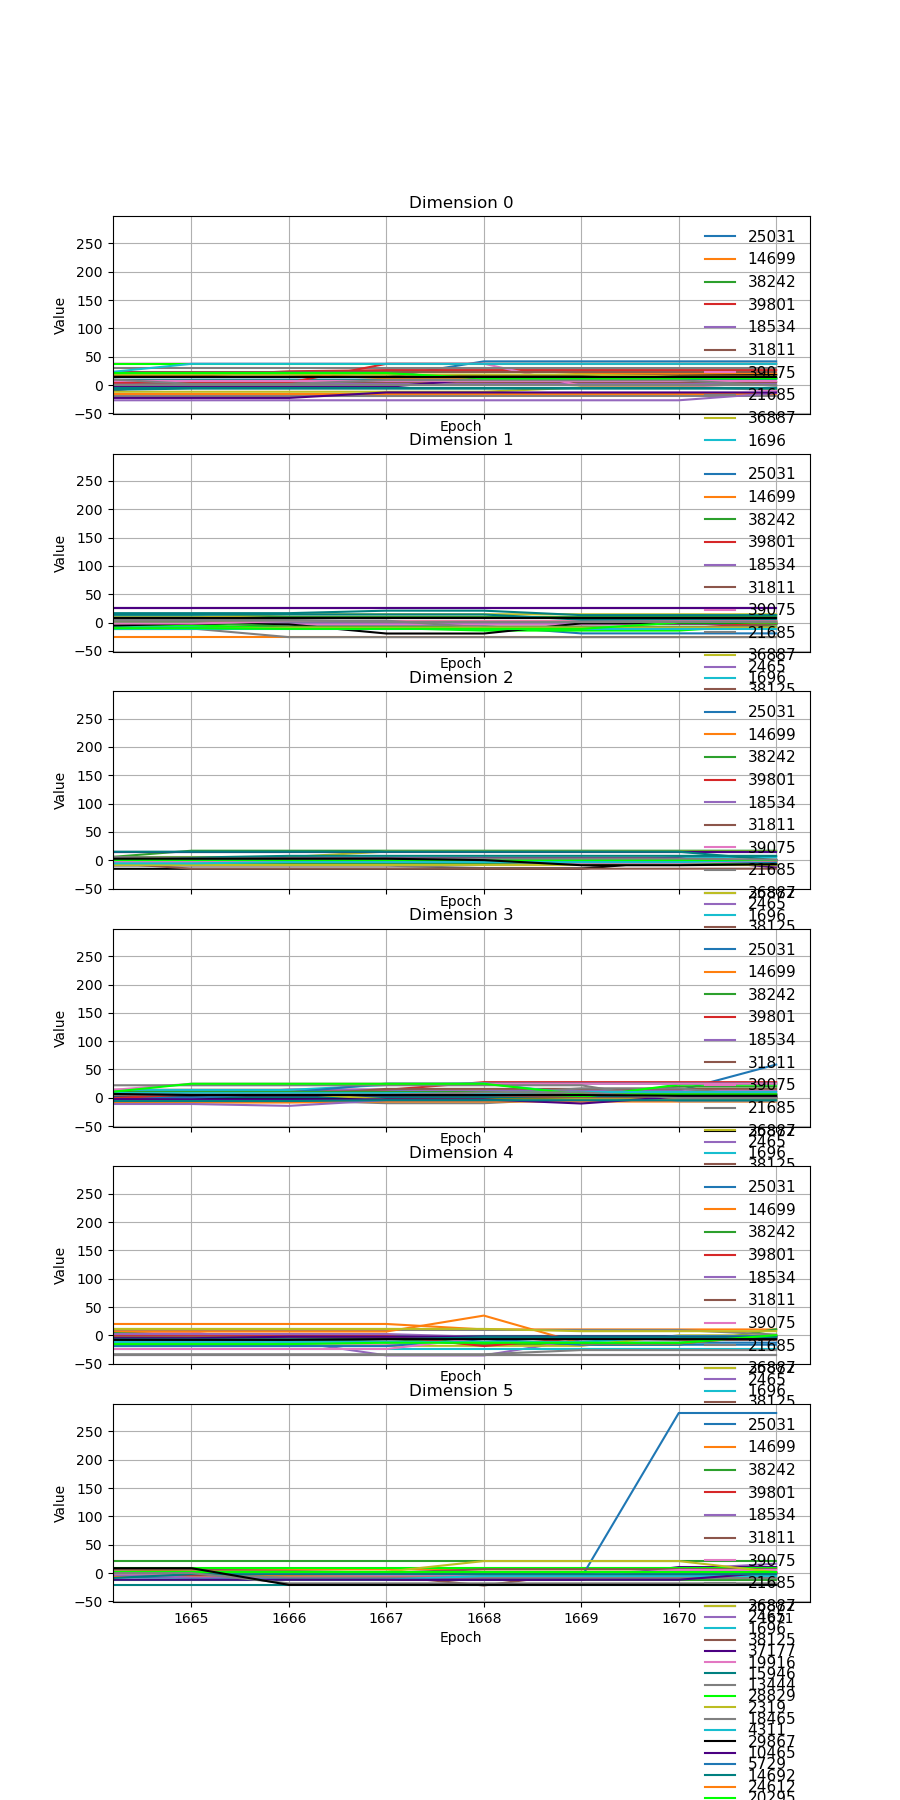

In [37]:
fig, axes = plt.subplots(nrows=chains2['X'].shape[-1], ncols=1, sharex=True, sharey=True, figsize=(9, 18))
for i in range(chains2['X'].shape[-1]):
    axes[i].set(title=f'Dimension {i}')
    plot_chains(axes[i], 
                epochs=chains2['curr_epoch'],
                chains=chains2['X'][:, :, i],
                labels=chains2['I'][0, :],
                ylim=None)


<IPython.core.display.Javascript object>


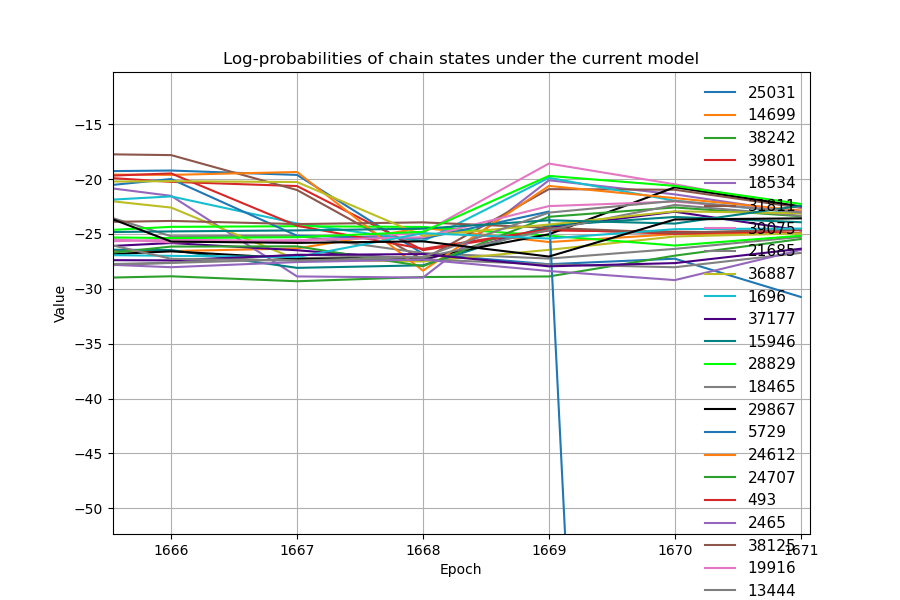

In [40]:
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(9, 6))

axes.set(title=f'Log-probabilities of chain states under the current model')
plot_chains(axes, 
            epochs=chains2['curr_epoch'], 
            chains=chains2['P'], 
            labels=chains2['I'][0, :],
            ylim=None)


We do not see any particularly big deviations from normal in these samples. The only deviation happens on the 1670-th epoch, which is after the start of explosion in 1669.

#### Investigate the imputation var. parameters at epoch 1668

In [83]:
group = 5
model = 'fa_variational_cdi_mi5_test'
var_params2 = trace_data_chains(dirname=log_path_template.format(group, model, 'tensors'),
                                logname='var_params',
                                epochs=chains2['curr_epoch'][1:], # Skip 0-th epoch because imputation starts from 1-st epoch
                                indices=max_idx.flatten())
# The indices of selected samples
var_params2['I'][0]

array([25031, 14699, 38242, 39801, 18534, 31811, 39075, 21685, 36887,
        1696, 37177, 15946, 28829, 18465, 29867,  5729, 24612, 24707,
         493,  2465, 38125, 19916, 13444,  2319,  4311, 10465, 14692,
       20295, 20586, 25872], dtype=int32)

In [84]:
var_params2['log_var'][var_params2['log_var'] == float('-inf')] = 0

<IPython.core.display.Javascript object>


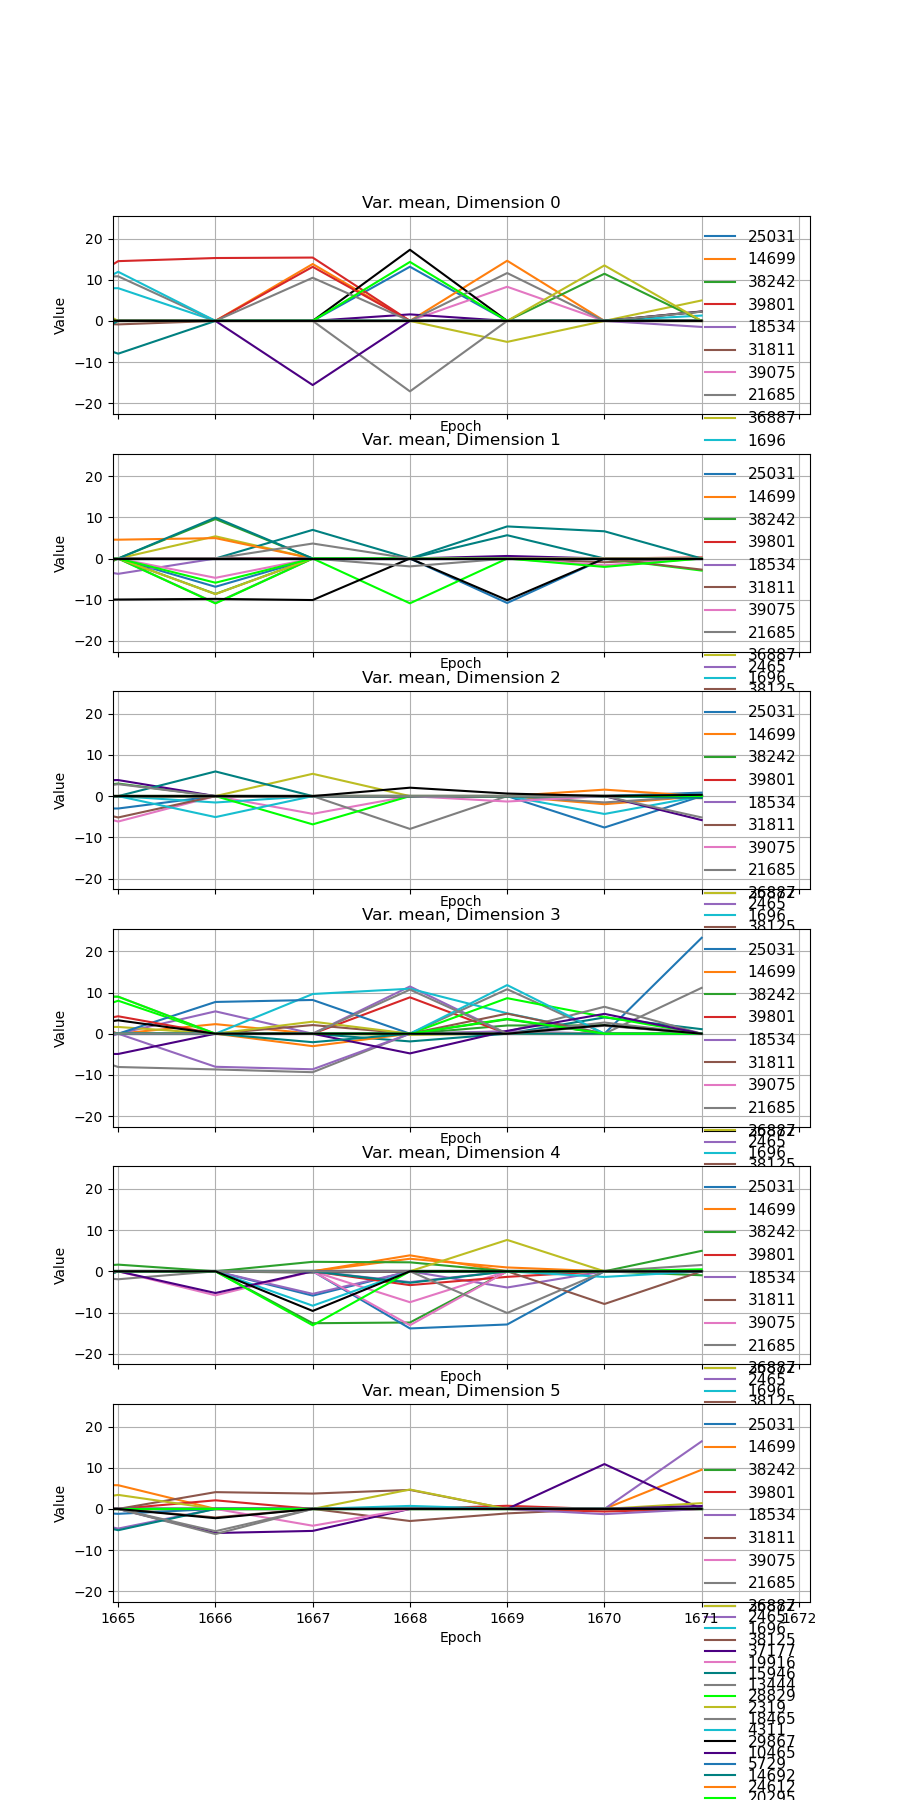

In [62]:
fig, axes = plt.subplots(nrows=var_params2['mean'].shape[-1], ncols=1, sharex=True, sharey=True, figsize=(9, 18))
for i in range(var_params2['mean'].shape[-1]):
    axes[i].set(title=f'Var. mean, Dimension {i}')
    plot_chains(axes[i], 
                epochs=var_params2['curr_epoch'], 
                chains=var_params2['mean'][:, :, i], 
                labels=var_params2['I'][0, :],
                ylim=None)


<IPython.core.display.Javascript object>


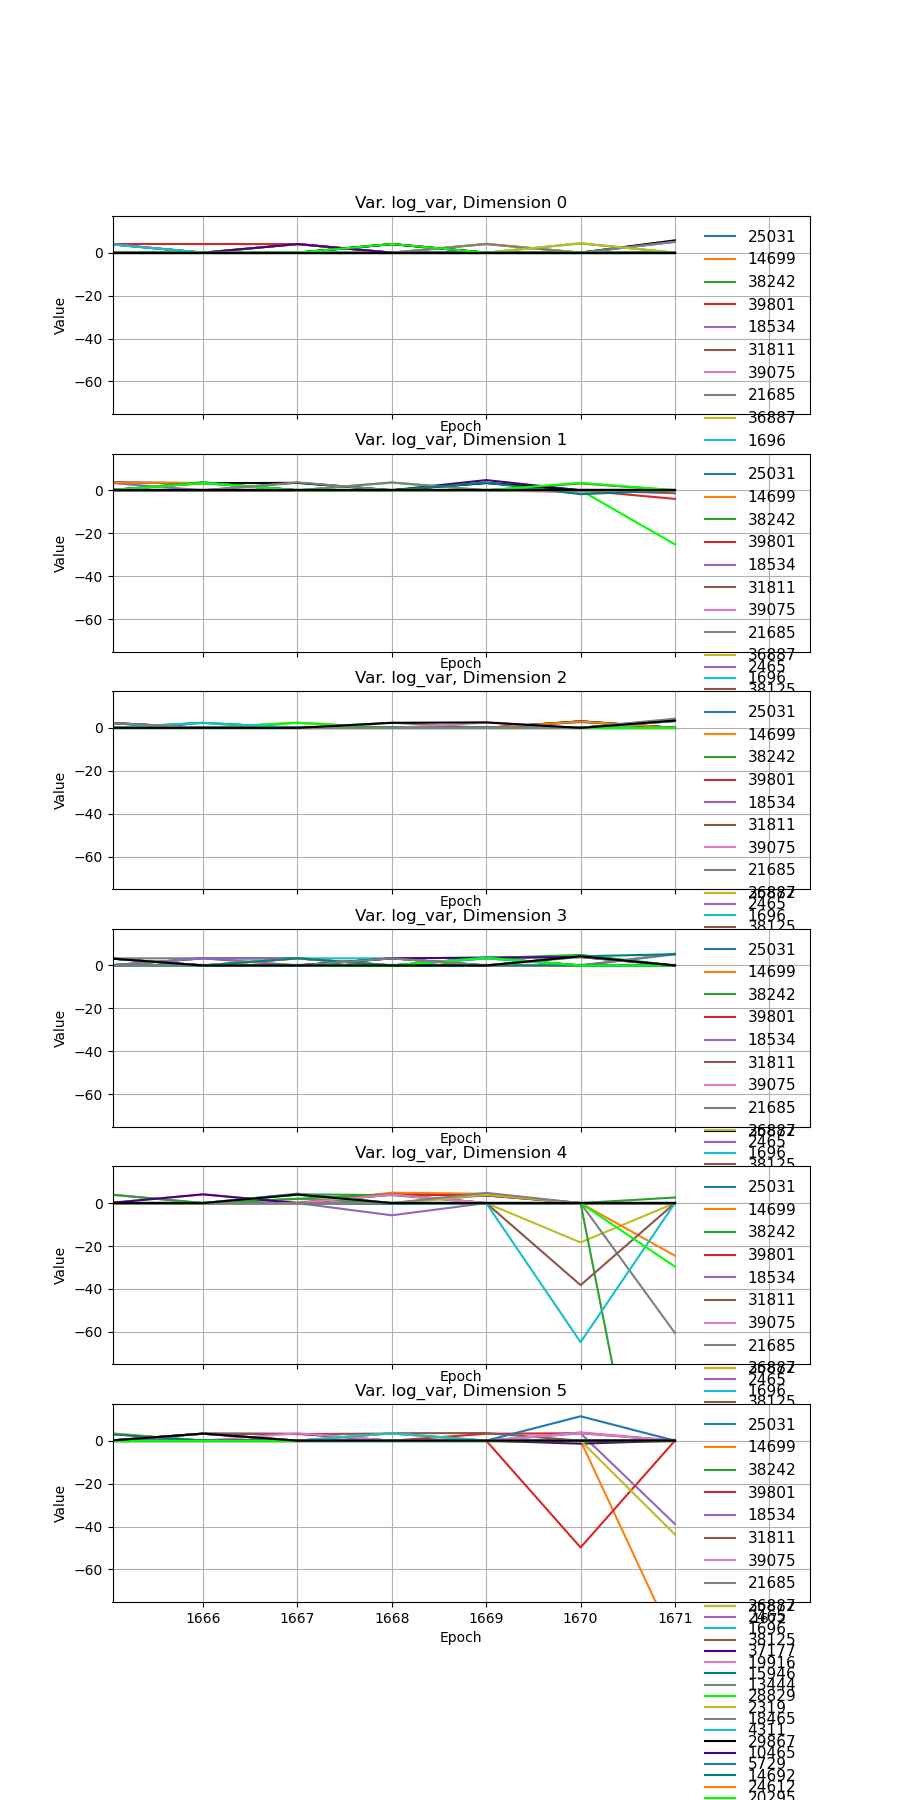

In [63]:
fig, axes = plt.subplots(nrows=var_params2['log_var'].shape[-1], ncols=1, sharex=True, sharey=True, figsize=(9, 18))
for i in range(var_params2['log_var'].shape[-1]):
    axes[i].set(title=f'Var. log_var, Dimension {i}')
    plot_chains(axes[i], 
                epochs=var_params2['curr_epoch'], 
                chains=var_params2['log_var'][:, :, i], 
                labels=var_params2['I'][0, :],
                ylim=None)


We do not see any anomalous variational posteriors pre-1669th epoch.

Only thing - the log_var in dim4 seems to be low for 2465 resulting in high confidence in predictions. 

In [75]:
# Find which sample had low log_var in the 1668-th epoch in 4-th dimension
epoch = 1668
dim=4
min_log_var = np.min(var_params2['log_var'][epoch-1, :, dim])
print(min_log_var)
min_log_var_idx_temp = np.argmin(var_params2['log_var'][epoch-1, :, dim])
print(var_params2['log_var'][epoch-1, min_log_var_idx_temp, dim])
min_log_var_idx = var_params2['I'][epoch-1, :][min_log_var_idx_temp]
min_log_var_idx

-5.687852
-5.687852


2465

In [79]:
# Get the sample from previous epoch (1667-th)
epoch = 1667
chains2['X'][epoch, min_log_var_idx_temp]

array([-26.952808 ,  25.556776 ,  13.651675 ,  -4.2242813,   2.4107838,
        -7.8805065], dtype=float32)

#### Check other imputation variational posteriors in 1668-th epoch

In [92]:
group = 5
model = 'fa_variational_cdi_mi5_test'
var_params3 = trace_data_chains(dirname=log_path_template.format(group, model, 'tensors'),
                                logname='var_params',
                                epochs=[1668] # Skip 0-th epoch because imputation starts from 1-st epoch
                                )
# The indices of selected samples
var_params3['I'][0]

array([    0,     1,     2, ..., 39997, 39998, 39999], dtype=int32)

In [93]:
var_params3['log_var'][var_params3['log_var'] == float('-inf')] = 0

In [95]:
torch.topk(torch.tensor(var_params3['log_var']).squeeze(), k=5, dim=0, largest=False)

torch.return_types.topk(
values=tensor([[ 0.0000,  0.0000,  0.0000,  0.0000, -5.6879,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000, -2.8299,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000, -2.6819,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000, -2.4270,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000, -1.9922,  0.0000]]),
indices=tensor([[    3,     3,     3,     1,  2465,     3],
        [    4,     4,     4,     4, 39207,     0],
        [    1,     1,     1,     0, 34465,     5],
        [    5,     0,     6,     5,  6629,     7],
        [    0,     2,     2,     2, 12561,     2]]))

##### Against epoch 1667

In [96]:
# Check epoch 1667
group = 5
model = 'fa_variational_cdi_mi5_test'
var_params4 = trace_data_chains(dirname=log_path_template.format(group, model, 'tensors'),
                                logname='var_params',
                                epochs=[1667] # Skip 0-th epoch because imputation starts from 1-st epoch
                                )
# The indices of selected samples
var_params4['I'][0]

array([    0,     1,     2, ..., 39997, 39998, 39999], dtype=int32)

In [97]:
var_params4['log_var'][var_params4['log_var'] == float('-inf')] = 0

In [98]:
torch.topk(torch.tensor(var_params4['log_var']).squeeze(), k=5, dim=0, largest=False)

torch.return_types.topk(
values=tensor([[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]]),
indices=tensor([[3, 3, 3, 3, 3, 1],
        [4, 1, 4, 4, 4, 4],
        [1, 0, 1, 0, 1, 0],
        [0, 6, 5, 5, 5, 5],
        [2, 2, 2, 2, 0, 2]]))

Above we see that in 1668-th epoch there are a number of _overconfident_ posteriors in the 4-th dimension. In the previous 1667-th epoch there were none.

Now we try to find what caused such a change in the variational model. This could potentially be caused by an underconfident posterior in the previous epoch.

In [99]:
torch.topk(torch.tensor(var_params3['log_var']).squeeze(), k=5, dim=0, largest=True)

torch.return_types.topk(
values=tensor([[4.0418, 3.6731, 2.3817, 3.3657, 5.4348, 3.6153],
        [4.0418, 3.6658, 2.3817, 3.3626, 5.4053, 3.5843],
        [4.0418, 3.6615, 2.3817, 3.3616, 5.3636, 3.5742],
        [4.0418, 3.6508, 2.3817, 3.3614, 5.3490, 3.5551],
        [4.0418, 3.6502, 2.3817, 3.3611, 5.3280, 3.5543]]),
indices=tensor([[15599, 13444, 22992,  6792, 37694, 14658],
        [15370,  6949,  2722, 26991, 37600,  6864],
        [20191, 38400, 10031, 17087,   468, 16240],
        [21569,  6682, 26312,  9681, 29561, 33196],
        [ 6283, 28785,  5495, 34258, 34530, 13148]]))

In [100]:
torch.topk(torch.tensor(var_params4['log_var']).squeeze(), k=5, dim=0, largest=True)

torch.return_types.topk(
values=tensor([[4.0180, 3.7207, 2.3882, 3.3594, 6.2238, 3.5673],
        [4.0180, 3.7033, 2.3882, 3.3594, 5.9427, 3.5463],
        [4.0180, 3.6940, 2.3882, 3.3582, 5.9286, 3.5429],
        [4.0180, 3.6909, 2.3882, 3.3580, 5.7559, 3.5289],
        [4.0180, 3.6874, 2.3882, 3.3577, 5.7509, 3.5257]]),
indices=tensor([[12750,  5380,  4176, 30324,  9465, 29670],
        [11610, 27164, 37964,  9681, 30437, 19936],
        [ 8541, 20586,  5157, 14415, 38859, 21264],
        [ 6864, 11663,  9243, 13024, 37678, 15575],
        [ 4743, 26610, 13261, 30807,   408,  4798]]))

We do not see a huge deviation here.

##### Against epoch 1666


In [101]:
# Check epoch 1666
group = 5
model = 'fa_variational_cdi_mi5_test'
var_params5 = trace_data_chains(dirname=log_path_template.format(group, model, 'tensors'),
                                logname='var_params',
                                epochs=[1666] # Skip 0-th epoch because imputation starts from 1-st epoch
                                )
# The indices of selected samples
var_params5['I'][0]

array([    0,     1,     2, ..., 39997, 39998, 39999], dtype=int32)

In [102]:
var_params5['log_var'][var_params5['log_var'] == float('-inf')] = 0

In [103]:
torch.topk(torch.tensor(var_params5['log_var']).squeeze(), k=5, dim=0, largest=True)

torch.return_types.topk(
values=tensor([[4.0409, 3.7048, 2.3572, 3.3756, 5.1930, 3.5084],
        [4.0409, 3.6731, 2.3572, 3.3745, 5.0529, 3.4969],
        [4.0409, 3.6580, 2.3572, 3.3729, 5.0315, 3.4920],
        [4.0409, 3.6506, 2.3572, 3.3725, 5.0050, 3.4874],
        [4.0409, 3.6474, 2.3572, 3.3722, 4.9591, 3.4780]]),
indices=tensor([[18602, 38242,  4176, 29632,  5694, 23828],
        [ 5191, 23734, 13261, 14262, 17986, 37684],
        [ 4623,  1632, 28176, 12461, 28452, 21818],
        [ 1108, 14268,  5258,  8233,  8586, 18130],
        [ 5847, 16286, 31214, 13182,  6142,  1011]]))

In [104]:
torch.topk(torch.tensor(var_params5['log_var']).squeeze(), k=5, dim=0, largest=False)

torch.return_types.topk(
values=tensor([[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]]),
indices=tensor([[3, 3, 3, 5, 3, 3],
        [4, 4, 4, 0, 4, 4],
        [1, 1, 1, 7, 1, 1],
        [0, 0, 6, 9, 0, 0],
        [2, 2, 5, 2, 2, 2]]))